In [1]:
import numpy as np
import pandas as pd

import phik
import math

import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
test = pd.read_csv('../data/test.csv')
test.shape

(565892, 55)

In [41]:
train = pd.read_csv('../data/train.csv')
train.shape

(15120, 56)

## Conclusions from the EDA:

- there's two types of quantitative/numerical data: continuous and discrete (binary)
- the dataset is free of nulls and duplicates
- the features 'Elevation', 'Horizontal Distance To Fire Points' and 'Horizontal Distance To Roadways' present high cardinality, but not enough to be removed
- only 'Vertical Distance To Hydrology' has negative values
- there's two colums ('Soil Type15' and 'Soil Type7') only with 0s, and many others with few 1s
- few features have correlation with the target
- the target is perfectly balanced

## 2. Outliers:

In [7]:
def number_of_outliers(df):
    
    df = df.select_dtypes(exclude = 'object')
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    return ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

In [8]:
number_of_outliers(train).sort_values().tail(10)

Soil_Type32                         690
Soil_Type30                         725
Soil_Type38                         728
Soil_Type23                         757
Horizontal_Distance_To_Roadways     830
Soil_Type4                          843
Soil_Type3                          962
Soil_Type29                        1291
Soil_Type10                        2142
Wilderness_Area1                   3597
dtype: int64

In [13]:
print('outliers in Wilderness Area 1: ' + str(3597/len(train)) + ' %')

outliers in Wilderness_Area1: 0.23789682539682538 %


 - As the outliers reflect the amplitude of the forest, we decide to keep them, and to choose outlier robust algorithms based in decision trees. 

## 2. Drop features with constant (or almost constant) values and id

In [4]:
train.shape

(15120, 56)

In [43]:
train.sum().sort_values().head(20)

Soil_Type7       0
Soil_Type15      0
Soil_Type25      1
Soil_Type8       1
Soil_Type28      9
Soil_Type36     10
Soil_Type9      10
Soil_Type27     15
Soil_Type21     16
Soil_Type34     22
Soil_Type37     34
Soil_Type19     46
Soil_Type26     54
Soil_Type18     60
Soil_Type35    102
Soil_Type16    114
Soil_Type20    139
Soil_Type5     165
Soil_Type14    169
Soil_Type12    227
dtype: int64

In [3]:
df = train.drop(columns= ['Soil_Type7', 'Soil_Type15', 'Soil_Type25', 'Soil_Type8', 'Id'])
df.shape

(15120, 51)

## 3. Correlations:

In [5]:
train = df

 - Pearson correlation:

In [6]:
abs(train.corrwith(train['Cover_Type'])).sort_values().tail(15)

Soil_Type24                        0.100797
Horizontal_Distance_To_Roadways    0.105662
Soil_Type35                        0.114327
Wilderness_Area3                   0.122146
Soil_Type10                        0.128972
Soil_Type12                        0.129985
Soil_Type32                        0.132312
Soil_Type23                        0.158762
Soil_Type22                        0.195993
Soil_Type40                        0.205851
Soil_Type29                        0.218564
Wilderness_Area1                   0.230117
Soil_Type39                        0.240384
Soil_Type38                        0.257810
Cover_Type                         1.000000
dtype: float64

In [44]:
abs(train.corrwith(train['Cover_Type'])).sort_values().head()

Soil_Type30    0.001393
Soil_Type34    0.003470
Soil_Type18    0.006312
Soil_Type6     0.006521
Aspect         0.008015
dtype: float64

- Phik correlation:

In [42]:
train.phik_matrix()['Cover_Type'].sort_values(ascending = False).head(25)

interval columns not set, guessing: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']


Cover_Type                            1.000000
Elevation                             0.801070
Wilderness_Area4                      0.754222
Horizontal_Distance_To_Roadways       0.494676
Soil_Type10                           0.492620
Soil_Type3                            0.483691
Wilderness_Area1                      0.483618
Soil_Type38                           0.445401
Horizontal_Distance_To_Fire_Points    0.440710
Soil_Type39                           0.419907
Wilderness_Area3                      0.361451
Soil_Type40                           0.353390
Soil_Type30                           0.326813
Soil_Type29                           0.322441
Horizontal_Distance_To_Hydrology      0.311203
Hillshade_9am                         0.303495
Hillshade_3pm                         0.292085
Aspect                                0.291317
Slope                                 0.281308
Soil_Type4                            0.279328
Soil_Type22                           0.271595
Soil_Type17  

In [45]:
train.phik_matrix()['Cover_Type'].sort_values(ascending = False).tail()

interval columns not set, guessing: ['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']


c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\phik\data_quality.py:74: UserWarning: Not enough unique value for variable Soil_Type7 for analysis 1. Dropping this column
  col, df[col].nunique()
c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\phik\data_quality.py:74: UserWarning: Not enough unique value for variable Soil_Type15 for analysis 1. Dropping this column
  col, df[col].nunique()


Soil_Type34    0.041158
Soil_Type28    0.034003
Soil_Type27    0.032027
Soil_Type25    0.000150
Soil_Type8     0.000150
Name: Cover_Type, dtype: float64

 - Thanks to the Phik correlation, we see that there are high correlations with the target, which helps us for the creation of new features.

## 4. Creation of new features:

In [7]:
train['eDist_to_Hydrology'] = (train['Horizontal_Distance_To_Hydrology']**2 + train['Vertical_Distance_To_Hydrology']**2)**0.5 
train['human_presence'] = train['Horizontal_Distance_To_Roadways'] + train['Horizontal_Distance_To_Fire_Points']
train['Total_Hillshade_mean'] = (train['Hillshade_9am'] + train['Hillshade_3pm'] + train['Hillshade_Noon']) / 3
train['Elevation_Aspect_ratio'] = train['Elevation']/(train['Aspect']+1)
train['Horizontal_Distance_To_Roadways_Log'] = [math.log(v+1) for v in train['Horizontal_Distance_To_Roadways']]
train['Hillshade_Noon_Aspect_ratio'] = train['Hillshade_Noon']/(train['Aspect']+1)
train['Hillshade_Noon_Elevation_ratio'] = train['Hillshade_Noon']/(train['Elevation']+1)
train['Hillshade_9am_Elevation_ratio'] = train['Hillshade_9am']/(train['Elevation']+1)


In [10]:
train.phik_matrix()['Cover_Type'].sort_values(ascending = False).head(25)

interval columns not set, guessing: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type', 'eDist_to_Hydrology', 'human_presence', 'Total_Hillshade_mean', 'Elevation_Aspect_ratio', 'Horizontal_Distanc

Cover_Type                             1.000000
Elevation                              0.801070
Wilderness_Area4                       0.754222
Hillshade_Noon_Elevation_ratio         0.617592
Hillshade_9am_Elevation_ratio          0.616461
human_presence                         0.527059
Horizontal_Distance_To_Roadways        0.494676
Soil_Type10                            0.492620
Soil_Type3                             0.483691
Wilderness_Area1                       0.483618
Soil_Type38                            0.445401
Horizontal_Distance_To_Fire_Points     0.440710
Horizontal_Distance_To_Roadways_Log    0.434802
Soil_Type39                            0.419907
Wilderness_Area3                       0.361451
Soil_Type40                            0.353390
Soil_Type30                            0.326813
Soil_Type29                            0.322441
Horizontal_Distance_To_Hydrology       0.311203
eDist_to_Hydrology                     0.308649
Hillshade_9am                          0

In [47]:
# train.to_csv('../data/train_newfeats.csv', index = False)

### 5. Transformations

In [8]:
train = pd.read_csv('../data/train_newfeats.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 59 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Elevation                            15120 non-null  int64  
 1   Aspect                               15120 non-null  int64  
 2   Slope                                15120 non-null  int64  
 3   Horizontal_Distance_To_Hydrology     15120 non-null  int64  
 4   Vertical_Distance_To_Hydrology       15120 non-null  int64  
 5   Horizontal_Distance_To_Roadways      15120 non-null  int64  
 6   Hillshade_9am                        15120 non-null  int64  
 7   Hillshade_Noon                       15120 non-null  int64  
 8   Hillshade_3pm                        15120 non-null  int64  
 9   Horizontal_Distance_To_Fire_Points   15120 non-null  int64  
 10  Wilderness_Area1                     15120 non-null  int64  
 11  Wilderness_Area2            

- subset with the continuous features:

In [13]:
cont_1 = train.iloc[:, 51:]
cont_2 = train.iloc[:, 0:10]

frames = [cont_1, cont_2]

cont = pd.concat(frames, axis= 1)


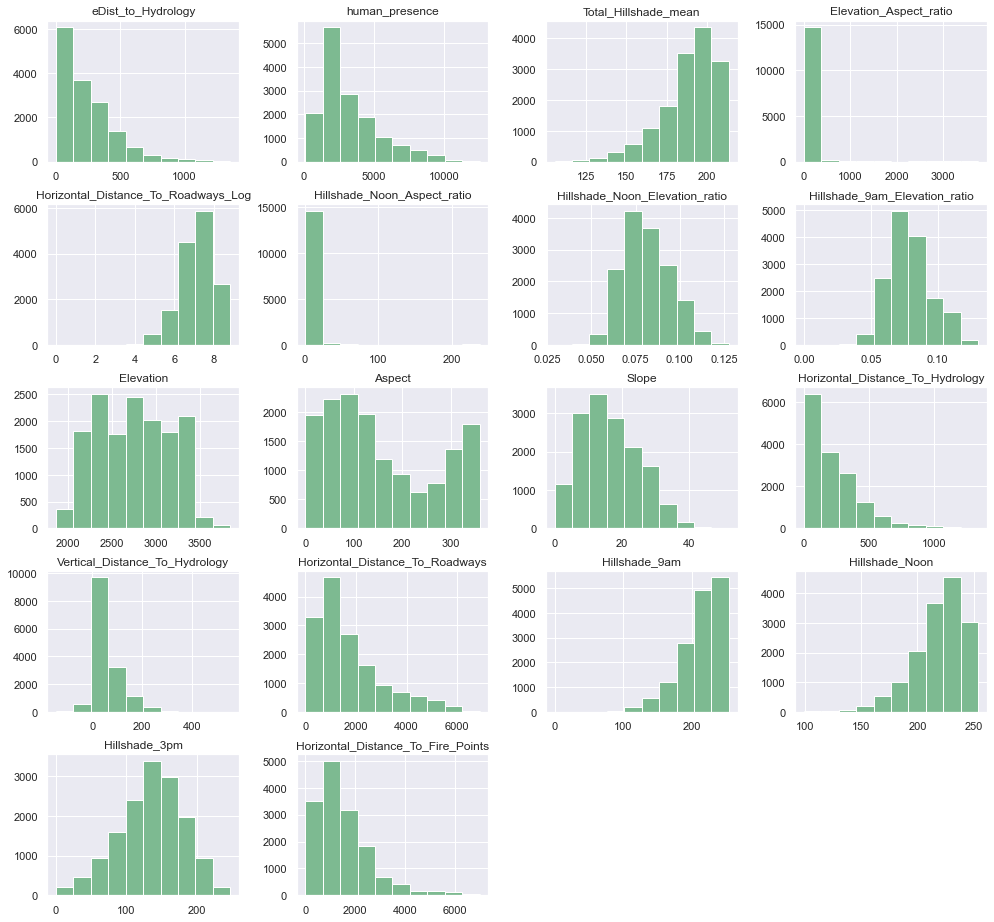

In [14]:
sns.set_theme(rc = {'figure.figsize':(15,15)}, palette='crest')

cont.hist(figsize=(15,15));

 - drop columns with almost constant values:

In [15]:
cont.drop(columns= ['Elevation_Aspect_ratio', 'Hillshade_Noon_Aspect_ratio'], inplace= True)
train.drop(columns= ['Elevation_Aspect_ratio', 'Hillshade_Noon_Aspect_ratio'], inplace= True)

 - check distributions:

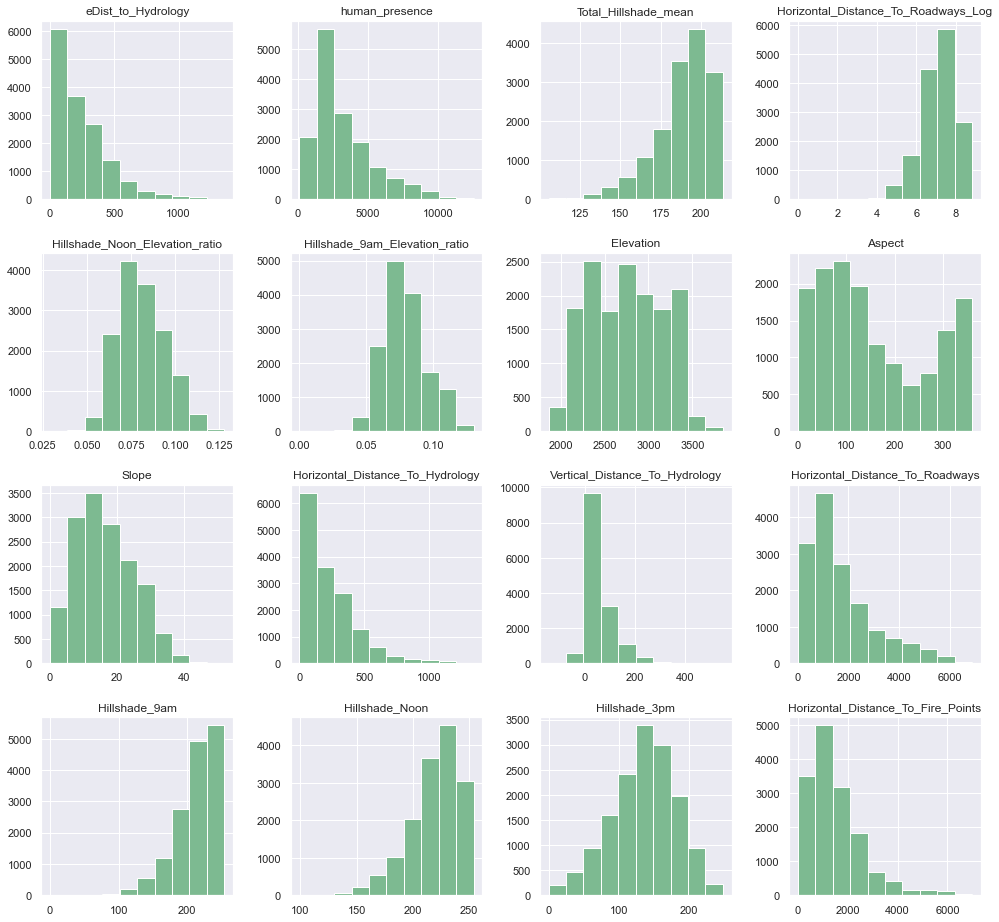

In [16]:
sns.set_theme(rc = {'figure.figsize':(15,15)}, palette='crest')

cont.hist(figsize=(15,15));

- subset with the discrete features:

In [32]:
disc = train.iloc[:, 10:50]

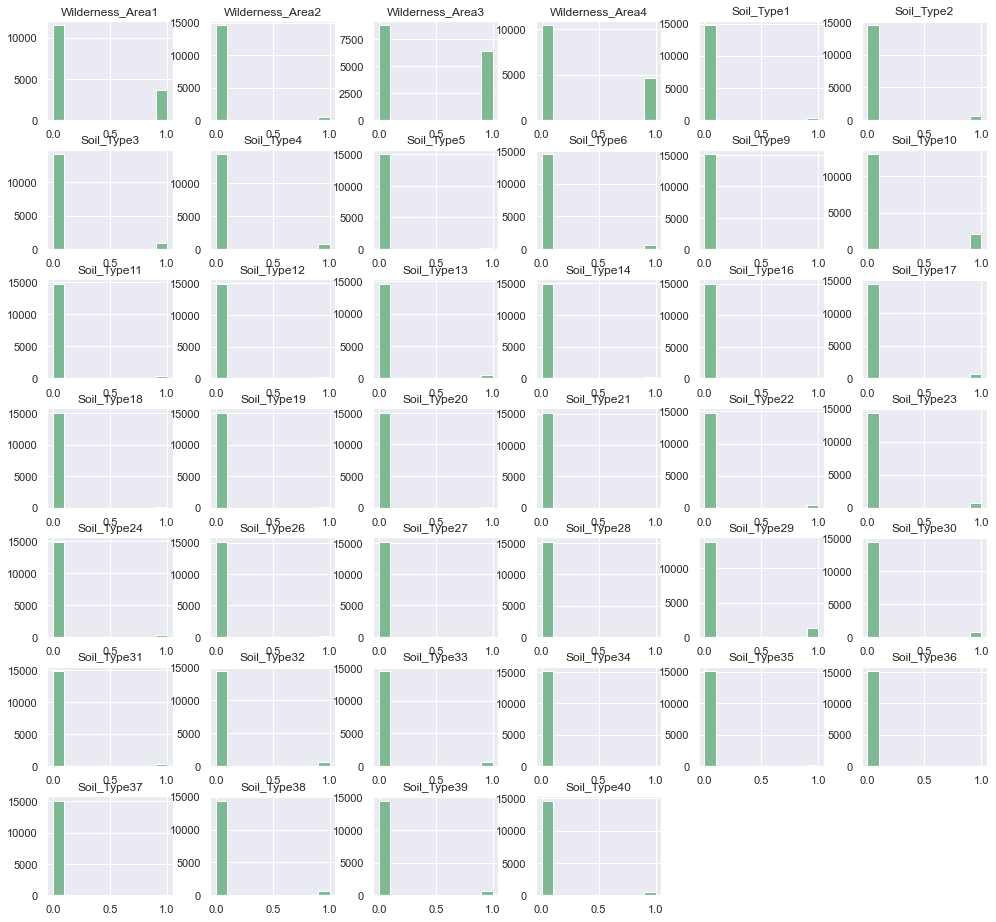

In [34]:
sns.set_theme(rc = {'figure.figsize':(15,15)}, palette='crest')

disc.hist(figsize=(15,15));

In [35]:
from scipy.stats import skew

In [39]:
# skewness along the index axis
# Para comprobar la asimetría de una variable siempre podemos calcular su valor skew
# 0 si es simetrica, >0 cola hacia la derecha, <0 cola hacia la izquierda
cont.skew(axis = 0, skipna = True).sort_values(ascending = False)

Horizontal_Distance_To_Fire_Points     1.617099
Vertical_Distance_To_Hydrology         1.537776
Horizontal_Distance_To_Hydrology       1.488052
eDist_to_Hydrology                     1.442072
human_presence                         1.301516
Horizontal_Distance_To_Roadways        1.247811
Slope                                  0.523658
Aspect                                 0.450935
Hillshade_9am_Elevation_ratio          0.364249
Hillshade_Noon_Elevation_ratio         0.329628
Elevation                              0.075640
Hillshade_3pm                         -0.340827
Horizontal_Distance_To_Roadways_Log   -0.689219
Hillshade_Noon                        -0.953232
Total_Hillshade_mean                  -1.090351
Hillshade_9am                         -1.093681
dtype: float64

In [38]:
disc.skew(axis = 0, skipna = True).sort_values(ascending = False)

Soil_Type28         40.955261
Soil_Type9          38.849712
Soil_Type36         38.849712
Soil_Type27         31.704896
Soil_Type21         30.695081
Soil_Type34         26.161230
Soil_Type37         21.018939
Soil_Type19         18.048915
Soil_Type26         16.645076
Soil_Type18         15.781426
Soil_Type35         12.052838
Soil_Type16         11.387050
Soil_Type20         10.286265
Soil_Type5           9.416209
Soil_Type14          9.300318
Soil_Type12          7.977205
Soil_Type24          7.474026
Soil_Type31          6.524804
Soil_Type22          6.391991
Soil_Type1           6.294716
Soil_Type11          5.854551
Soil_Type40          5.475256
Soil_Type13          5.366836
Wilderness_Area2     5.228781
Soil_Type17          4.663945
Soil_Type33          4.646742
Soil_Type2           4.617019
Soil_Type6           4.506716
Soil_Type39          4.479186
Soil_Type32          4.354839
Soil_Type30          4.231913
Soil_Type38          4.221771
Soil_Type23          4.126701
Soil_Type4

 - normalizing the skewness:

In [10]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

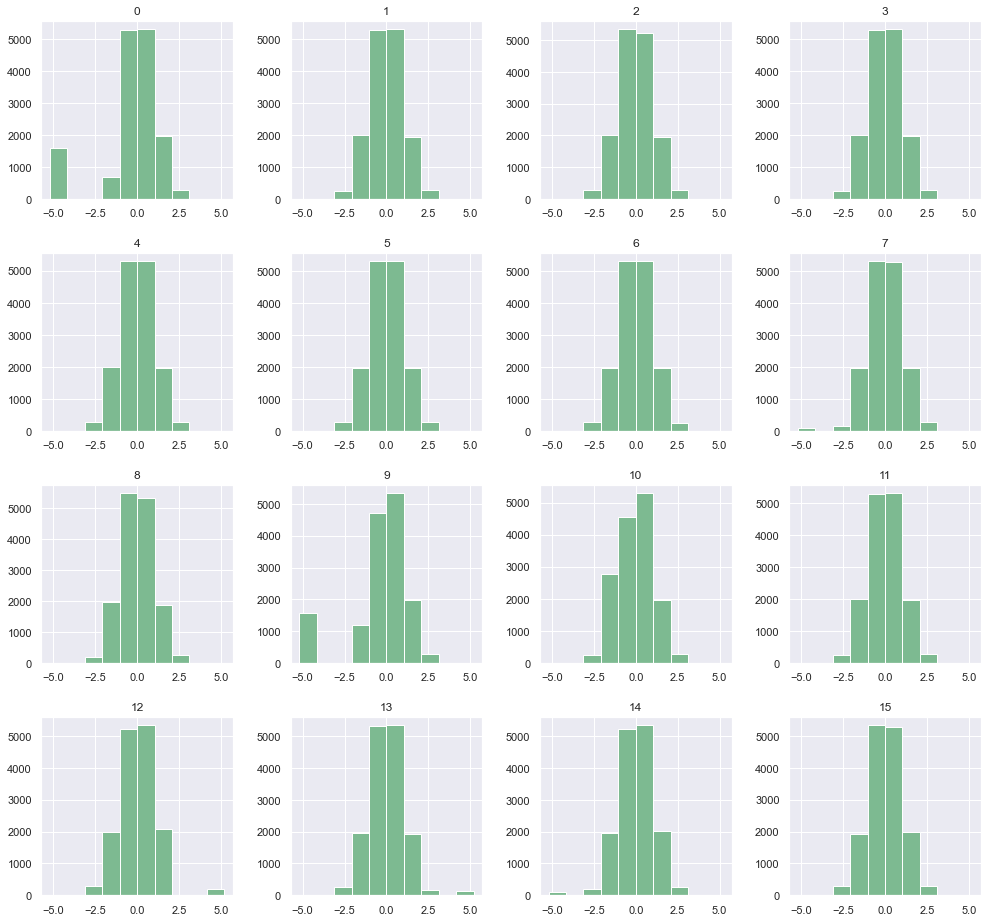

In [41]:
# perform a normal quantile transform of the cont df

trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
data = trans.fit_transform(cont)
# convert the array back to a dataframe
cont_trans = pd.DataFrame(data)
# histograms of the variables

# sns.set_theme(rc = {'figure.figsize':(15,15)}, palette='crest')
cont_trans.hist(figsize=(15,15));

#### Comparing skewness before and after the transformation:

In [92]:
data_tuples = list(zip(cont.skew(axis = 0, skipna = True),cont_trans.skew(axis = 0, skipna = True)))
comp_skew = pd.DataFrame(data_tuples, columns=['original','transformed'])
comp_skew

,original,transformed
0,1.442072,-1.685962
1,1.301516,0.004554
2,-1.090351,0.035114
3,-0.689219,-0.008694
4,0.329628,0.008146
5,0.364249,0.006744
6,0.075640,0.025288
7,0.450935,-0.662534
8,0.523658,-0.045447
9,1.488052,-1.693894


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import lightgbm as lgb
import xgboost


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.feature_selection import SelectKBest

from sklearn.pipeline import Pipeline

In [12]:
train.shape

(15120, 59)

In [13]:
trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
data = trans.fit_transform(train)
# convert the array back to a dataframe
trans_train = pd.DataFrame(data)

In [14]:
trans_train.columns

RangeIndex(start=0, stop=59, step=1)

In [17]:
train.shape

(15120, 59)

In [16]:
train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17',
       'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
       'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type', 'eDist_to_Hydrology',
       'human_presence', '

In [18]:
trans_train.columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17',
       'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
       'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type', 'eDist_to_Hydrology',
       'human_presence', 'Total_Hillshade_mean', 'Elevation_Aspect_ratio',
       'Horizontal_Distance_To_Roadways_Log', 'Hillshade_Noon_Aspect_ratio',
       'Hillshade_Noon_Elevation_ratio', 'Hillshade_9am_Elevation_ratio']


# feature selection

#### PCAs

In [36]:
from sklearn.decomposition import PCA

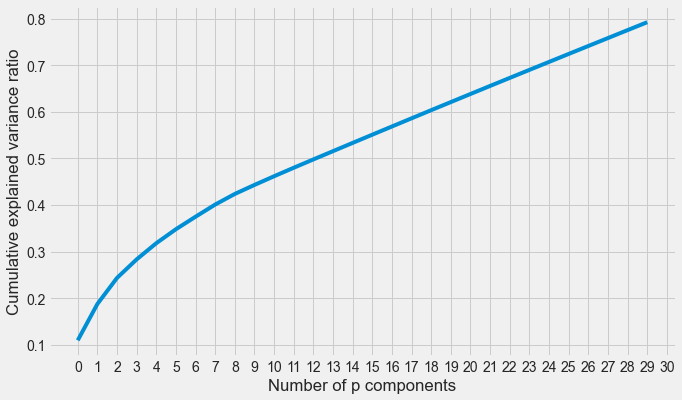

In [40]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(trans_train)

pca = PCA(n_components=30)
X_pca = pca.fit_transform(train_scaled)

plt.figure(figsize = (10,6))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of p components")
plt.ylabel("Cumulative explained variance ratio")
plt.xticks(np.arange(0,31));

#### Feature Importances

In [19]:
trans_train['Cover_Type'] = train['Cover_Type']

In [20]:
X= trans_train.drop(['Cover_Type'], axis=1) 
y= trans_train['Cover_Type']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC


scaler = MinMaxScaler()
scaler.fit(X_train) 

X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [21]:
# initialize the classificators
rfc= RandomForestClassifier(random_state=77)
gbc= GradientBoostingClassifier(random_state=77)
ada = AdaBoostClassifier(random_state=77)
etc = ExtraTreesClassifier(random_state=77)
lgbm = lgb.LGBMClassifier(random_state=77)
knn = KNeighborsClassifier()
lSVC = LinearSVC()


# now, create a list with the objects 
models= [rfc, gbc, ada, etc, lgbm]
models_2 = [knn, lSVC]

In [22]:
for model in models:
    model.fit(X_train, y_train) 
    train_score= model.score(X_train, y_train) 
    test_score= model.score(X_test, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.85


The score in train of model GradientBoostingClassifier is 0.86
The score in test of model GradientBoostingClassifier is 0.81


The score in train of model AdaBoostClassifier is 0.35
The score in test of model AdaBoostClassifier is 0.35


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.86


The score in train of model LGBMClassifier is 0.99
The score in test of model LGBMClassifier is 0.86




In [96]:
for model in models_2:
    model.fit(X_train_scal, y_train)
    train_score= model.score(X_train_scal, y_train) 
    test_score= model.score(X_test_scal, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model KNeighborsClassifier is 0.87
The score in test of model KNeighborsClassifier is 0.79


The score in train of model LinearSVC is 0.68
The score in test of model LinearSVC is 0.67




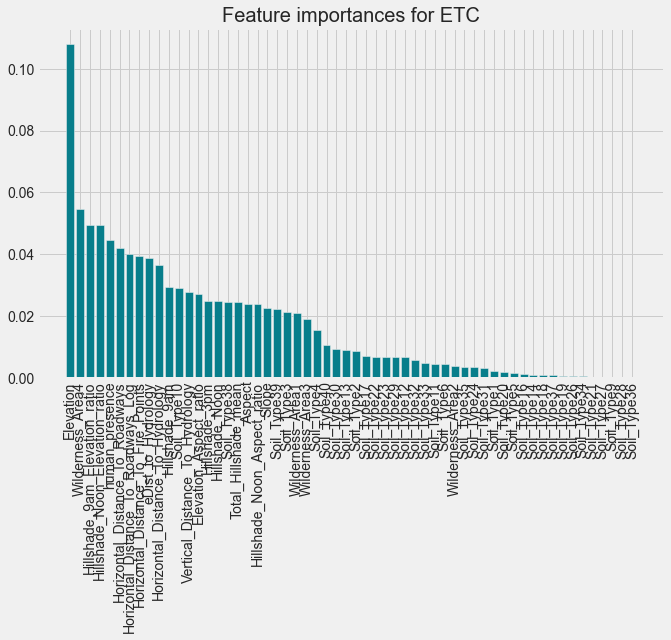

In [23]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': etc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize = (10,6))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances for ETC', size=20)
plt.xticks(rotation='vertical')
plt.show()

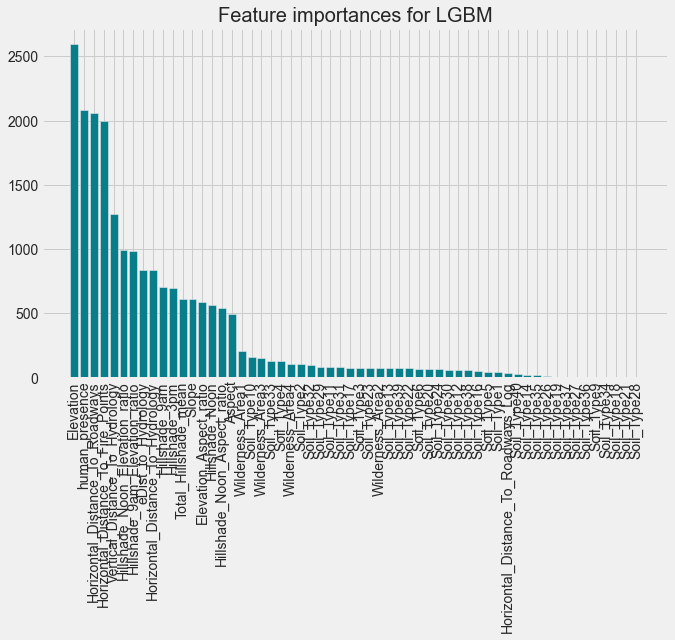

In [24]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': lgbm.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize = (10,6))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances for LGBM', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [28]:
importances.head(20)

,Attribute,Importance
0,Elevation,2593
51,human_presence,2084
5,Horizontal_Distance_To_Roadways,2063
9,Horizontal_Distance_To_Fire_Points,1998
4,Vertical_Distance_To_Hydrology,1270
56,Hillshade_Noon_Elevation_ratio,990
57,Hillshade_9am_Elevation_ratio,983
50,eDist_to_Hydrology,841
3,Horizontal_Distance_To_Hydrology,835
6,Hillshade_9am,707


#### Features importances for LGBM:

In [34]:
X = trans_train[['Elevation', 'human_presence', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
'Vertical_Distance_To_Hydrology', 'Hillshade_Noon_Elevation_ratio', 'Hillshade_9am_Elevation_ratio', 'eDist_to_Hydrology', 'Horizontal_Distance_To_Hydrology',
'Hillshade_9am', 'Hillshade_3pm', 'Total_Hillshade_mean', 'Slope', 'Elevation_Aspect_ratio', 'Hillshade_Noon', 'Hillshade_Noon_Aspect_ratio']]
y= trans_train['Cover_Type']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)

In [35]:
lgbm.fit(X_train, y_train) 
train_score= model.score(X_train, y_train) 
test_score= model.score(X_test, y_test)
#clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
#print(clf_report)
print("\n")

The score in train of model LGBMClassifier is 0.99
The score in test of model LGBMClassifier is 0.83




#### Selekt K best

In [70]:
from sklearn.feature_selection import SelectKBest

print(X.shape)
sel = SelectKBest(k=5)
X_new = sel.fit_transform(X, y)
names = X.columns

print(X_new.shape)

best_feats = pd.DataFrame({'column': names, 'score': sel.scores_}).sort_values('score', ascending=False)
best_feats

(15120, 56)
(15120, 5)


,column,score
0,Elevation,10145.162072
13,Wilderness_Area4,5072.497908
54,Hillshade_Noon_Elevation_ratio,3129.271591
55,Hillshade_9am_Elevation_ratio,2259.972737
51,human_presence,1605.027644
53,Horizontal_Distance_To_Roadways_Log,1097.160226
5,Horizontal_Distance_To_Roadways,1093.163581
21,Soil_Type10,977.737621
16,Soil_Type3,929.217593
10,Wilderness_Area1,928.831132


#### Selekt K Best and Features importances for ETC point to the same features:

In [29]:
X= trans_train[['Elevation', 'Wilderness_Area4', 'Hillshade_Noon_Elevation_ratio', 'Hillshade_9am_Elevation_ratio', 'human_presence', 
'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Roadways_Log', 'Soil_Type10', 'Soil_Type3', 'Wilderness_Area1', 'Horizontal_Distance_To_Fire_Points',
 'Soil_Type38', 'Soil_Type39', 'Horizontal_Distance_To_Hydrology']]
y= trans_train['Cover_Type']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)

In [76]:
for model in models:
    model.fit(X_train, y_train) 
    train_score= model.score(X_train, y_train) 
    test_score= model.score(X_test, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.86


The score in train of model GradientBoostingClassifier is 0.84
The score in test of model GradientBoostingClassifier is 0.79


The score in train of model AdaBoostClassifier is 0.43
The score in test of model AdaBoostClassifier is 0.42


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.87


The score in train of model LGBMClassifier is 0.98
The score in test of model LGBMClassifier is 0.84




In [98]:
for model in models_2:
    model.fit(X_train_scal, y_train)
    train_score= model.score(X_train_scal, y_train) 
    test_score= model.score(X_test_scal, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model KNeighborsClassifier is 0.40
The score in test of model KNeighborsClassifier is 0.14


The score in train of model LinearSVC is 0.17
The score in test of model LinearSVC is 0.15




## Conclusions:

 - the PCAs reveals that we need most of the features in order to achieve a good model
 - the best features for ETC and LGBM models show tha certain types of sole are irrelevant for the predictions (9, 19, 21, 27, 28, 34, 36...)
 - the SelectKBest tool includes also the variable 'Aspect' and two more types of soils (6 and 30)
 - the Phik correlation includes also the soils 8 and 25.

We can see that the less relevant soil types only have few values, so let's drop it:

In [46]:
train.sum().sort_values().head(20)

Soil_Type7       0
Soil_Type15      0
Soil_Type25      1
Soil_Type8       1
Soil_Type28      9
Soil_Type36     10
Soil_Type9      10
Soil_Type27     15
Soil_Type21     16
Soil_Type34     22
Soil_Type37     34
Soil_Type19     46
Soil_Type26     54
Soil_Type18     60
Soil_Type35    102
Soil_Type16    114
Soil_Type20    139
Soil_Type5     165
Soil_Type14    169
Soil_Type12    227
dtype: int64

In [47]:
X= trans_train.drop(['Cover_Type', 'Soil_Type28', 'Soil_Type36', 'Soil_Type9', 'Soil_Type27', 'Soil_Type21', 'Soil_Type34'], axis=1) 
y= trans_train['Cover_Type']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)

In [48]:
for model in models:
    model.fit(X_train, y_train) 
    train_score= model.score(X_train, y_train) 
    test_score= model.score(X_test, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.87


The score in train of model GradientBoostingClassifier is 0.85
The score in test of model GradientBoostingClassifier is 0.81


The score in train of model AdaBoostClassifier is 0.29
The score in test of model AdaBoostClassifier is 0.29


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.88


The score in train of model LGBMClassifier is 0.99
The score in test of model LGBMClassifier is 0.87




In [50]:
train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [51]:
# save the data wothout transforming, XQ IRÄ EN LOS PIPELINES

# df= train.drop(['Soil_Type28', 'Soil_Type36', 'Soil_Type9', 'Soil_Type27', 'Soil_Type21', 'Soil_Type34'], axis=1) 

# df.to_csv('../data/train_newfeats_drop.csv', index = False)

In [126]:
abs(train.corrwith(train['Cover_Type'])).sort_values(ascending=False).head(7)

Cover_Type          1.000000
Soil_Type38         0.257810
Soil_Type39         0.240384
Wilderness_Area1    0.230117
Soil_Type29         0.218564
Soil_Type40         0.205851
Soil_Type22         0.195993
dtype: float64

In [136]:
correlatio = train[['Cover_Type','Soil_Type38', 'Soil_Type39', 'Wilderness_Area1', 'Soil_Type29', 'Soil_Type40', 'Soil_Type22']]

<AxesSubplot:>

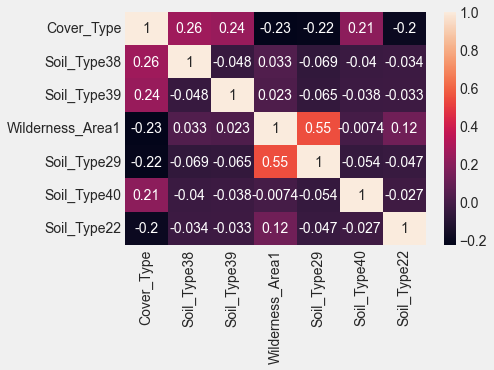

In [137]:
sns.heatmap(correlatio.corr(), annot=True)

In [ ]:
# Soil_Type38         0.257810
# Soil_Type39         0.240384
# Wilderness_Area1    0.230117

In [132]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor


# X, y = train.drop("Cover_Type", axis=1), train["Cover_Type"]

# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
  
# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                           for i in range(len(X.columns))]
  
# print(vif_data)

c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                               feature         VIF
0                                   Id    1.395556
1                            Elevation   12.210669
2                               Aspect    1.958110
3                                Slope    9.372777
4     Horizontal_Distance_To_Hydrology    2.459628
5       Vertical_Distance_To_Hydrology    2.247968
6      Horizontal_Distance_To_Roadways    2.094913
7                        Hillshade_9am  121.233223
8                       Hillshade_Noon   46.393454
9                        Hillshade_3pm  183.408121
10  Horizontal_Distance_To_Fire_Points    1.739212
11                    Wilderness_Area1         inf
12                    Wilderness_Area2         inf
13                    Wilderness_Area3         inf
14                    Wilderness_Area4         inf
15                          Soil_Type1         inf
16                          Soil_Type2         inf
17                          Soil_Type3         inf
18                          Soi

- create new features from those

In [54]:
# none works, NO RELATED with feat with corr
# # add new features from feature engineering
# train['Elev_to_Horizontal_Hyd'] = train.Elevation - 0.2 * train.Horizontal_Distance_To_Hydrology 
# train['Elev_to_Horizontal_Road'] = train.Elevation - 0.05 * train.Horizontal_Distance_To_Roadways  
# train['Elev_to_Verticle_Hyd'] = train.Elevation - train.Vertical_Distance_To_Hydrology 
# train['Mean_Horizontal_Dist'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology + 
#                                  train.Horizontal_Distance_To_Roadways)/3 
# train['Mean_Fire_Hydro'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology)/2

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# the independent variables set
X, y = train.drop("Cover_Type", axis=1), train["Cover_Type"]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
cor = pd.DataFrame(data=train.copy().corrwith(train['Cover_Type']))
cor['feature'] = cor.index
cor.rename(columns = {0:'corr_target'}, inplace = True)

feat_cor = pd.merge(vif_data, cor, on="feature")
# feat_cor.head()
best_feat = feat_cor[(feat_cor['VIF'] < 7) & (feat_cor['corr_target'] > 0.2)]
best_feat

c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF,corr_target
